# **Advance Computer Vision - Project 1**

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.5.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import time
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,Reshape, Flatten, Conv1D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
from PIL import Image

# **PART 1**

> **PROJECT OBJECTIVE: Face detection from training images.**



### **1. Import the dataset.**

In [14]:
data = np.load('/content/drive/MyDrive/Dataset/Dataset- Images.npy',allow_pickle=True)

In [15]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [16]:
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

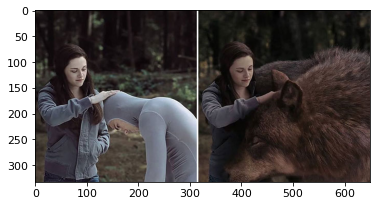

In [17]:
plt.imshow(data[0][0])

### **2. Create features (images) and labels (mask) using that data.**

In [18]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [19]:
X.shape, masks.shape

((409, 128, 128, 3), (409, 128, 128))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


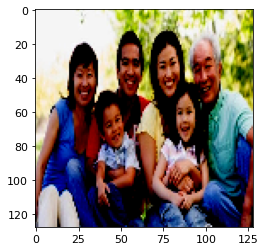

In [20]:
plt.imshow(X[4])

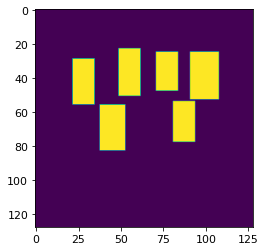

In [21]:
plt.imshow(masks[4])

In [22]:
train_x, test_x = train_test_split(X, test_size=0.10, random_state=42)
train_y, test_y = train_test_split(masks, test_size=0.10, random_state=42)

In [23]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((368, 128, 128, 3), (41, 128, 128, 3), (368, 128, 128), (41, 128, 128))

### **3. Mask detection model:**

**● Design a face mask detection model.Hint: Use U-net along with pre-trained transfer learning models.**

In [24]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

**● Design your own Dice Coefficient and Loss function.**

In [25]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [26]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [27]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 64, 64, 32)   0           conv1_bn[0][0]                   
_____________________________

**● Train, tune and test the model.**

In [28]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [29]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [30]:
#model.fit(X, masks, epochs=30, batch_size=10, verbose=1)

In [31]:
model.fit(train_x, train_y, validation_data = (test_x, test_y), epochs=50, batch_size=20, verbose=1)

Epoch 1/50
19/19 [==============================] - 43s 447ms/step - loss: 1.6068 - dice_coefficient: 0.3500 - val_loss: 1.3015 - val_dice_coefficient: 0.3788
Epoch 2/50
19/19 [==============================] - 7s 358ms/step - loss: 1.0572 - dice_coefficient: 0.4879 - val_loss: 1.6440 - val_dice_coefficient: 0.3362
Epoch 3/50
19/19 [==============================] - 7s 355ms/step - loss: 0.8485 - dice_coefficient: 0.5574 - val_loss: 1.3638 - val_dice_coefficient: 0.4158
Epoch 4/50
19/19 [==============================] - 7s 350ms/step - loss: 0.7491 - dice_coefficient: 0.5905 - val_loss: 1.3614 - val_dice_coefficient: 0.4284
Epoch 5/50
19/19 [==============================] - 7s 347ms/step - loss: 0.6896 - dice_coefficient: 0.6188 - val_loss: 1.2739 - val_dice_coefficient: 0.4567
Epoch 6/50
19/19 [==============================] - 7s 347ms/step - loss: 0.6439 - dice_coefficient: 0.6362 - val_loss: 1.1924 - val_dice_coefficient: 0.4798
Epoch 7/50
19/19 [==============================] -

**● Evaluate the model using testing data.**

In [32]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 1s 426ms/step - loss: 0.8187 - dice_coefficient: 0.6234


[0.8186984062194824, 0.6234122514724731]

In [33]:
testing_pred = model.predict(test_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


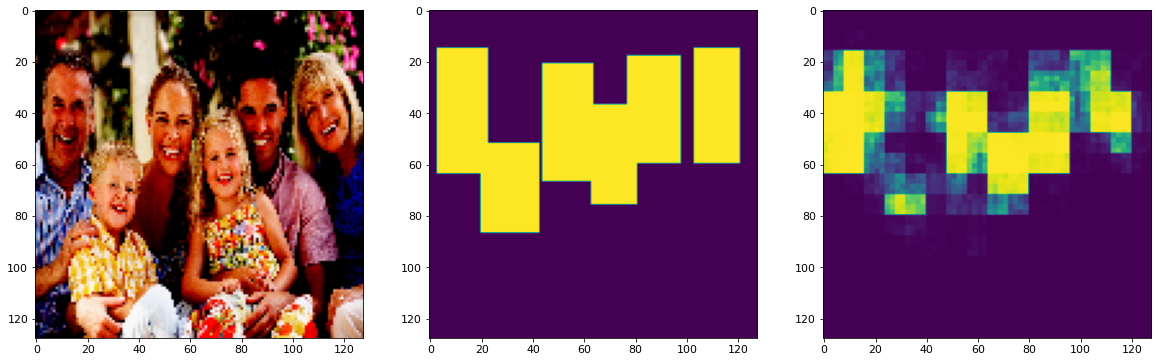

In [34]:
figure, j = plt.subplots(1, 3, figsize=(20, 20))
j[0].imshow(test_x[0])
j[1].imshow(test_y[0])
j[2].imshow(testing_pred[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


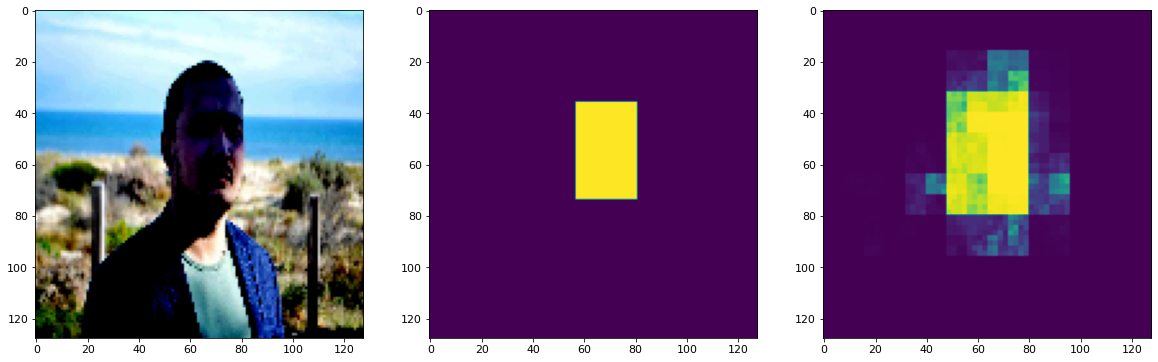

In [35]:
figure, j = plt.subplots(1, 3, figsize=(20, 20))
j[0].imshow(test_x[40])
j[1].imshow(test_y[40])
j[2].imshow(testing_pred[40])

### **4. Use the “Prediction image” as an input to your designed model and display the output of the image.**

In [36]:
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/Dataset/Prediction_Image.jpeg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

output_image = image2

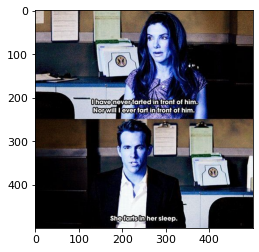

In [37]:
plt.imshow(unscaled)

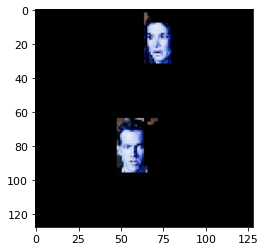

In [38]:
plt.imshow(output_image)

# **PART 2**

> **TASK: Help to create an image dataset to be used by the AI team to build an image classifier data.**

> Images are taken from real-and-fake-face-detection data





**X and Y Coordinates of an Object in an Image using OpenCV**

Face
x1:  413
x2:  415

y1:  479
y2:  481



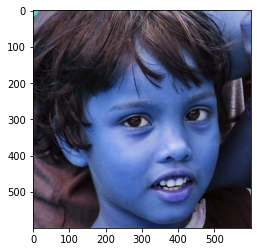

In [5]:
image= cv2.imread('/content/drive/MyDrive/Dataset/training_real/real_00001.jpg')
original_image= image
gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 50,200)
contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= False)
largest_item= sorted_contours[1]
#largest item
M= cv2.moments(largest_item)
x,y,w,h= cv2.boundingRect(largest_item)
xcoordinate1= x 
xcoordinate2= x + w
print("Face")
print("x1: ", str(xcoordinate1))
print("x2: ", str(xcoordinate2))
print("")
ycoordinate1= y 
ycoordinate2= y + h
print("y1: ", str(ycoordinate1))
print("y2: ", str(ycoordinate2))
print("")
plt.imshow(image)
plt.show()

**X and Y Coordinates of an Object in an Image using YOLOv5s model**

In [6]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True,force_reload=True)

img1 ='/content/drive/MyDrive/Dataset/training_real/real_00001.jpg'
img2 ='/content/drive/MyDrive/Dataset/training_real/real_00002.jpg'
img3 = '/content/drive/MyDrive/Dataset/Prediction_Image.jpeg'
# Images
imgs = [img1,img2,img3]  # batch of images

# Inference
results = model(imgs)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-8-1 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)



Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [7]:
image_1 = results.pandas().xyxy[0]
image_2 = results.pandas().xyxy[1]
image_3 = results.pandas().xyxy[2]
results.print()

image 1/3: 600x600 1 person
image 2/3: 600x600 1 person
image 3/3: 500x500 2 persons, 2 chairs
Speed: 16.7ms pre-process, 8.6ms inference, 1.5ms NMS per image at shape (3, 3, 640, 640)


**Image 1 output:**

(<matplotlib.image.AxesImage at 0x7f450b155750>,
    xmin  ymin   xmax   ymax  confidence  class    name
 0   0.0   0.0  600.0  600.0     0.48584      0  person)

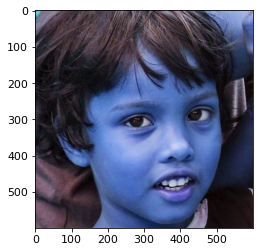

In [8]:
plt.imshow(cv2.imread(img1)),image_1

In [9]:
image_1

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.0,0.0,600.0,600.0,0.48584,0,person


**Image 2 output:**

(<matplotlib.image.AxesImage at 0x7f450b0dde90>,
         xmin      ymin        xmax        ymax  confidence  class    name
 0  27.890623  3.046875  599.999939  595.312439    0.543945      0  person)

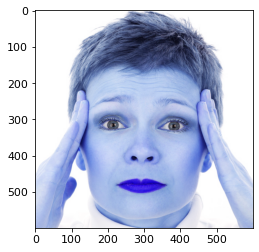

In [10]:
plt.imshow(cv2.imread(img2)),image_2

In [11]:
image_2

,xmin,ymin,xmax,ymax,confidence,class,name
0,27.890623,3.046875,599.999939,595.312439,0.543945,0,person


**Image 3 output:**

image 1/3: 600x600 1 person
image 2/3: 600x600 1 person
image 3/3: 500x500 2 persons, 2 chairs
Speed: 16.7ms pre-process, 8.6ms inference, 1.5ms NMS per image at shape (3, 3, 640, 640)


(<matplotlib.image.AxesImage at 0x7f450b047590>, None)

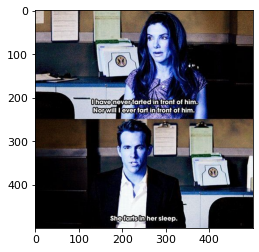

In [12]:
plt.imshow(cv2.imread(img3)),results.print()

In [13]:
image_3

,xmin,ymin,xmax,ymax,confidence,class,name
0,117.187500,253.906250,350.390625,500.000000,0.863281,0,person
1,192.675781,4.296875,405.468750,253.320312,0.820801,0,person
2,395.703125,427.343750,499.609375,499.218750,0.488525,56,chair
3,0.439453,186.230469,92.041016,250.000000,0.474854,56,chair


- **challenges faced during this task:**


*   Tried two approaches to get the coordinates of the face, with open cv and YOLOv5s. In 1st approach it was difficult to get the number of faces by extracting contours. 
*   In 2nd approach I have load a pretrained YOLOv5s model and passes an image for inference. which gives xmin, ymin, xmax, ymax, confidence, class, names and number of objects in the image. 







